In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [11]:
import pandas as pd
import os

base_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(base_dir, "data")
train_csv_path = os.path.join(data_dir, 'train_1.csv')
train_images_dir = os.path.join(data_dir, 'train_images')

train_df = pd.read_csv(train_csv_path)


In [12]:
def preprocess_image(img_path, img_size=(224, 224)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = cv2.resize(img, img_size)

    img = img.astype('float32') / 255.0

    return img


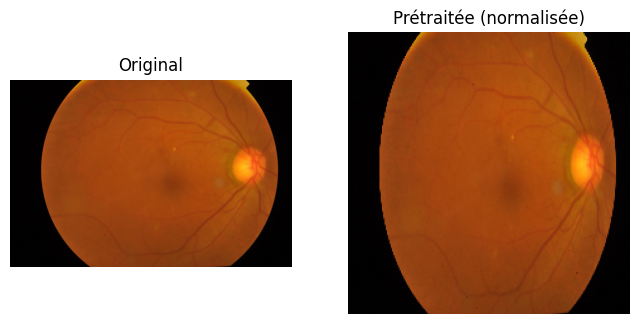

In [14]:
sample_id = train_df.iloc[0]['id_code']
sample_path = os.path.join(train_images_dir, f"{sample_id}.png")

img_original = cv2.imread(sample_path)
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

img_processed = preprocess_image(sample_path)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img_original)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_processed)
plt.title("Prétraitée (normalisée)")
plt.axis("off")
plt.show()


## Processed images

In [18]:
from tqdm import tqdm

def process_and_save_images(csv_path, images_dir, output_filename, img_size=(224, 224)):
    df = pd.read_csv(csv_path)

    X = []
    y = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        img_id = row['id_code']
        label = row['diagnosis']
        img_path = os.path.join(images_dir, f"{img_id}.png")

        if os.path.exists(img_path):
            img = preprocess_image(img_path, img_size=img_size)
            X.append(img)
            y.append(label)

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int32)

    np.savez_compressed(output_filename, X=X, y=y)
    print(f"{output_filename} sauvegardé ✅ | Shape : {X.shape}, {y.shape}")

In [19]:
# Train
process_and_save_images(
    csv_path=os.path.join(data_dir, 'train_1.csv'),
    images_dir=os.path.join(data_dir, 'train_images'),
    output_filename=os.path.join(base_dir, 'processed_train_images.npz')
)

# Validation
process_and_save_images(
    csv_path=os.path.join(data_dir, 'valid.csv'),
    images_dir=os.path.join(data_dir, 'val_images'),
    output_filename=os.path.join(base_dir, 'processed_val_images.npz')
)

# Test
process_and_save_images(
    csv_path=os.path.join(data_dir, 'test.csv'),
    images_dir=os.path.join(data_dir, 'test_images'),
    output_filename=os.path.join(base_dir, 'processed_test_images.npz')
)









































































































































































































































































































































































































































































































































































































































































































































































































































































100%|██████████| 2930/2930 [02:12<00:00, 22.19it/s]


c:\Users\pc\Projects\RetinopathyDetection\processed_train_images.npz sauvegardé ✅ | Shape : (2930, 224, 224, 3), (2930,)



































































































































100%|██████████| 366/366 [00:19<00:00, 18.84it/s]


c:\Users\pc\Projects\RetinopathyDetection\processed_val_images.npz sauvegardé ✅ | Shape : (366, 224, 224, 3), (366,)




































































































































100%|██████████| 366/366 [00:18<00:00, 19.30it/s]


c:\Users\pc\Projects\RetinopathyDetection\processed_test_images.npz sauvegardé ✅ | Shape : (366, 224, 224, 3), (366,)


In [1]:
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
base_dir = os.path.dirname(os.getcwd())
train_augmented_path = os.path.join(base_dir, 'processed_train_images_augmented.npz')
val_path = os.path.join(base_dir, 'processed_val_images.npz')

train_data = np.load(train_augmented_path)
X_train, y_train = train_data['X'], train_data['y']

val_data = np.load(val_path)
X_val, y_val = val_data['X'], val_data['y']


In [5]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import albumentations as A
import matplotlib.pyplot as plt

base_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(base_dir, "data")
train_csv_path = os.path.join(data_dir, 'train_1.csv')
train_images_dir = os.path.join(data_dir, 'train_images')

train_df = pd.read_csv(train_csv_path)
print("Colonnes disponibles:", train_df.columns.tolist()) 

def get_train_augmentations():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        A.CLAHE(p=0.5),
        A.Blur(blur_limit=3, p=0.1),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.1),
        A.CoarseDropout(max_holes=8, max_height=20, max_width=20, p=0.2),
    ])

def get_valid_augmentations():
    return A.Compose([
        A.Normalize()
    ])

def preprocess_image(img_path, img_size=(224, 224), is_training=True):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Impossible de charger l'image: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    transform = get_train_augmentations() if is_training else get_valid_augmentations()
    augmented = transform(image=img)
    img = augmented['image']
    
    img = cv2.resize(img, img_size)
    img = img.astype('float32') / 255.0
    return img

def load_dataset(df, img_dir, is_training=True):
    images = []
    labels = []
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        try:
            img_path = os.path.join(img_dir, row['id_code'] + '.png') 
            if not os.path.exists(img_path):
                print(f"Fichier introuvable: {img_path}")
                continue
                
            img = preprocess_image(img_path, is_training=is_training)
            images.append(img)
            labels.append(row['diagnosis'])
        except Exception as e:
            print(f"Erreur avec {row['id_code']}: {str(e)}")
            continue
    
    return np.array(images), np.array(labels)

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

X_train, y_train = load_dataset(train_df, train_images_dir, is_training=True)
X_val, y_val = load_dataset(val_df, train_images_dir, is_training=False)

print(f"Forme des données d'entraînement: {X_train.shape}")
print(f"Forme des labels d'entraînement: {y_train.shape}")

Colonnes disponibles: ['id_code', 'diagnosis']


  0%|          | 0/2344 [00:00<?, ?it/s]c:\Users\pc\Projects\RetinopathyDetection\venv\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\pc\AppData\Local\Temp\ipykernel_25560\1556142567.py:27: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.1),
C:\Users\pc\AppData\Local\Temp\ipykernel_25560\1556142567.py:28: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=20, max_width=20, p=0.2),
100%|██████████| 586/586 [00:50<00:00, 11.54it/s]

Forme des données d'entraînement: (2344, 224, 224, 3)
Forme des labels d'entraînement: (2344,)


In [ ]:
print(train_df.columns)
print(train_df.head())

Index(['id_code', 'diagnosis'], dtype='object')
           id_code  diagnosis
381   35aa7f5c2ec0          1
834   530d78467615          2
1898  9f8112c710be          0
678   4a96c28f3f07          0
700   4c52922f3bfd          2


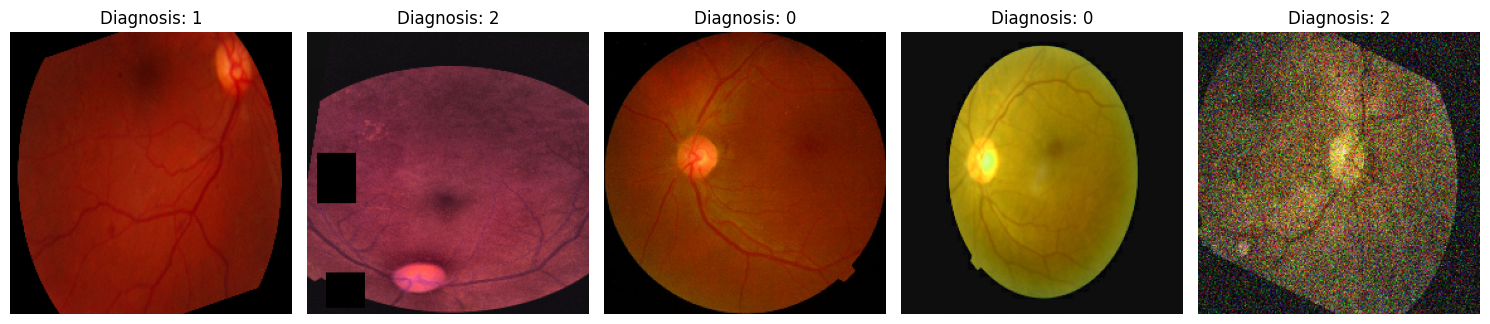

In [6]:
def visualize_samples(images, labels, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[i])
        plt.title(f"Diagnosis: {labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples(X_train, y_train)

### FILTRES

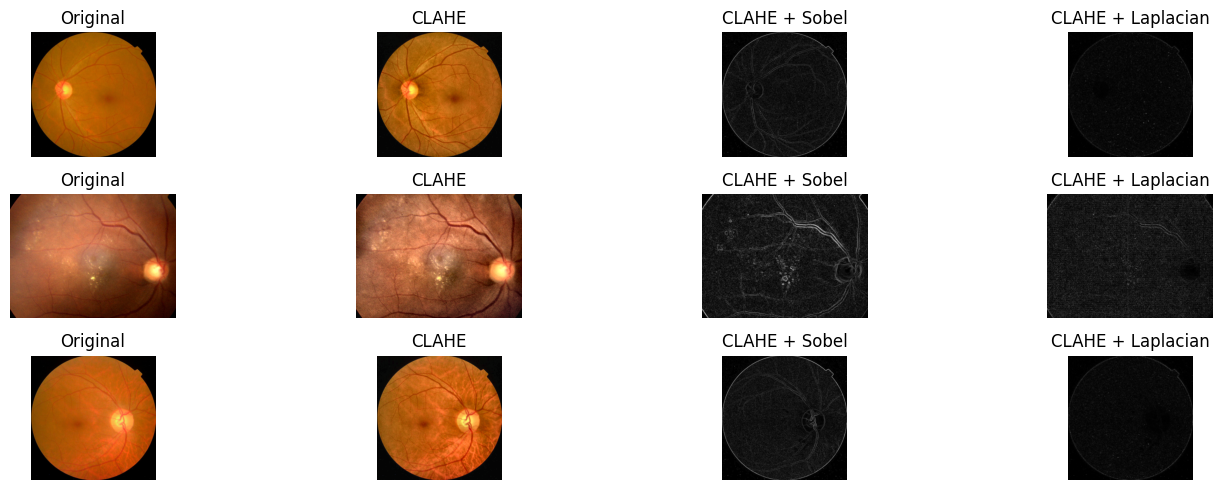

In [6]:
import random
import os
import cv2
import matplotlib.pyplot as plt

def apply_clahe(img):
    img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(img_lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l_clahe = clahe.apply(l)
    img_lab_clahe = cv2.merge((l_clahe, a, b))
    img_clahe = cv2.cvtColor(img_lab_clahe, cv2.COLOR_LAB2RGB)
    return img_clahe

def apply_sobel(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    sobel = np.hypot(sobelx, sobely)
    sobel = np.uint8(sobel / np.max(sobel) * 255)
    return sobel

def apply_laplacian(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    laplacian = np.uint8(np.abs(laplacian) / np.max(np.abs(laplacian)) * 255)
    return laplacian

img_dir = os.path.join("..", "data", "train_images")
img_dir = os.path.abspath(img_dir)

img_files = [f for f in os.listdir(img_dir) if f.endswith(".png") or f.endswith(".jpg")]

indices = random.sample(range(len(img_files)), 3)

plt.figure(figsize=(15, 5))

for idx, i in enumerate(indices):
    img_path = os.path.join(img_dir, img_files[i])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_clahe = apply_clahe(img)
    sobel = apply_sobel(img_clahe)
    laplacian = apply_laplacian(img_clahe)
    
    plt.subplot(3, 4, 4*idx+1)
    plt.imshow(img)
    plt.title('Original')
    plt.axis('off')
    
    plt.subplot(3, 4, 4*idx+2)
    plt.imshow(img_clahe)
    plt.title('CLAHE')
    plt.axis('off')

    plt.subplot(3, 4, 4*idx+3)
    plt.imshow(sobel, cmap='gray')
    plt.title('CLAHE + Sobel')
    plt.axis('off')

    plt.subplot(3, 4, 4*idx+4)
    plt.imshow(laplacian, cmap='gray')
    plt.title('CLAHE + Laplacian')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [11]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm


In [8]:
def apply_clahe_color(image):
    """Applique CLAHE individuellement sur les 3 canaux BGR"""
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    final = cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)
    return final

def load_and_process_images(image_dir, df, img_size=(224, 224)):
    X, y = [], []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        img_path = os.path.join(image_dir, row['id_code'] + '.png')
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = apply_clahe_color(img)
            img = cv2.resize(img, img_size)
            img = img.astype('float32') / 255.0
            X.append(img)
            y.append(row['diagnosis'])
    return np.array(X), np.array(y)


In [9]:
base_dir = "../data"

train_df = pd.read_csv(os.path.join(base_dir, "train_1.csv"))
val_df = pd.read_csv(os.path.join(base_dir, "valid.csv"))
test_df = pd.read_csv(os.path.join(base_dir, "test.csv"))


In [12]:
train_images_dir = os.path.join(base_dir, "train_images")
X_train, y_train = load_and_process_images(train_images_dir, train_df)

np.savez_compressed(os.path.join(base_dir, "processed_train_images_filtred.npz"),
                    X=X_train, y=y_train)
print("✅ Données train sauvegardées.")


100%|██████████| 2930/2930 [06:14<00:00,  7.82it/s]


✅ Données train sauvegardées.


In [13]:
val_images_dir = os.path.join(base_dir, "val_images")
X_val, y_val = load_and_process_images(val_images_dir, val_df)

np.savez_compressed(os.path.join(base_dir, "processed_val_images_filtred.npz"),
                    X=X_val, y=y_val)
print("✅ Données val sauvegardées.")


100%|██████████| 366/366 [00:49<00:00,  7.35it/s]


✅ Données val sauvegardées.


In [14]:
test_images_dir = os.path.join(base_dir, "test_images")
X_test, y_test = load_and_process_images(test_images_dir, test_df)

np.savez_compressed(os.path.join(base_dir, "processed_test_images_filtred.npz"),
                    X=X_test, y=y_test)
print("✅ Données test sauvegardées.")


100%|██████████| 366/366 [00:46<00:00,  7.86it/s]


✅ Données test sauvegardées.


In [16]:
import numpy as np
import albumentations as A
from albumentations.core.composition import OneOf
from tqdm import tqdm

In [18]:
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=20, p=0.4),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=0, p=0.3),
    A.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.0), p=0.3)
])


In [19]:
data = np.load("../data/processed_train_images_filtred.npz")
X_train, y_train = data["X"], data["y"]

In [20]:
X_aug = []
y_aug = []

for i in tqdm(range(len(X_train))):
    image = (X_train[i] * 255).astype(np.uint8) 
    augmented = augment(image=image)["image"]
    augmented = augmented.astype(np.float32) / 255.0 
    X_aug.append(augmented)
    y_aug.append(y_train[i])


100%|██████████| 2930/2930 [00:03<00:00, 867.08it/s]


In [21]:
X_aug = np.array(X_aug)
y_aug = np.array(y_aug)

np.savez_compressed("../data/processed_train_images_filtred_augmented.npz", X=X_aug, y=y_aug)
print("✅ Dataset augmenté sauvegardé.")


✅ Dataset augmenté sauvegardé.


In [6]:
import numpy as np

data = np.load("../data/processed_train_images_filtred.npz")
X, y = data["X"], data["y"]
print("Shapes :", X.shape, y.shape)


Shapes : (2930, 224, 224, 3) (2930,)


In [7]:
indices_class_3 = np.where(y == 3)[0]
indices_class_4 = np.where(y == 4)[0]

X_3, y_3 = X[indices_class_3], y[indices_class_3]
X_4, y_4 = X[indices_class_4], y[indices_class_4]


In [11]:
import albumentations as A
from albumentations import HorizontalFlip, ShiftScaleRotate, RandomBrightnessContrast
from tqdm import tqdm

augmentor = A.Compose([
    HorizontalFlip(p=0.5),
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.5),
    RandomBrightnessContrast(p=0.3),
])

def augment_images(images, labels, n_aug=5):
    augmented = []
    for img, label in tqdm(zip(images, labels), total=len(images)):
        for _ in range(n_aug):
            aug = augmentor(image=img)["image"]
            augmented.append((aug, label))
    return zip(*augmented)

X_aug_3, y_aug_3 = augment_images(X_3, y_3, n_aug=10)
X_aug_4, y_aug_4 = augment_images(X_4, y_4, n_aug=10)


c:\Users\pc\Projects\RetinopathyDetection\venv\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/154 [00:00<?, ?it/s]

100%|██████████| 234/234 [00:03<00:00, 65.54it/s]


In [12]:
X_final = np.concatenate([X, np.array(X_aug_3), np.array(X_aug_4)], axis=0)
y_final = np.concatenate([y, np.array(y_aug_3), np.array(y_aug_4)], axis=0)

np.savez("../data/processed_train_images_filtred_augmented.npz", images=X_final, labels=y_final)
print("Données augmentées sauvegardées.")


Données augmentées sauvegardées.


In [1]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Devices:", tf.config.list_physical_devices('GPU'))


Num GPUs Available: 0
GPU Devices: []


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10059482038108014142
xla_global_id: -1
]


In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import cv2
import numpy as np

In [11]:
base_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(base_dir, "data")
train_csv_path = os.path.join(data_dir, 'train_1.csv')
train_images_dir = os.path.join(data_dir, 'train_images')

train_df = pd.read_csv(train_csv_path)
print(train_df.head())

        id_code  diagnosis
0  1ae8c165fd53          2
1  1b329a127307          1
2  1b32e1d775ea          4
3  1b3647865779          0
4  1b398c0494d1          0


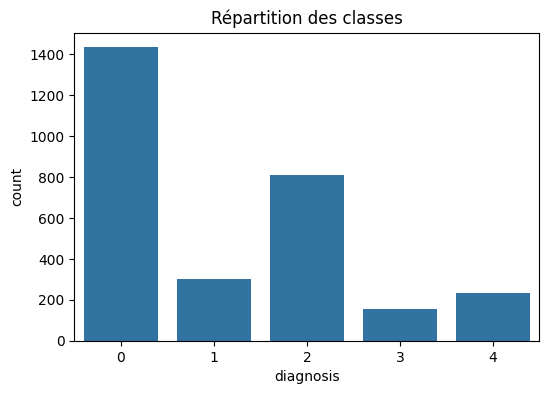

In [19]:
plt.figure(figsize=(6,4))
sns.countplot(data=train_df, x='diagnosis', order=sorted(train_df['diagnosis'].unique()))
plt.title("Répartition des classes")
plt.show()


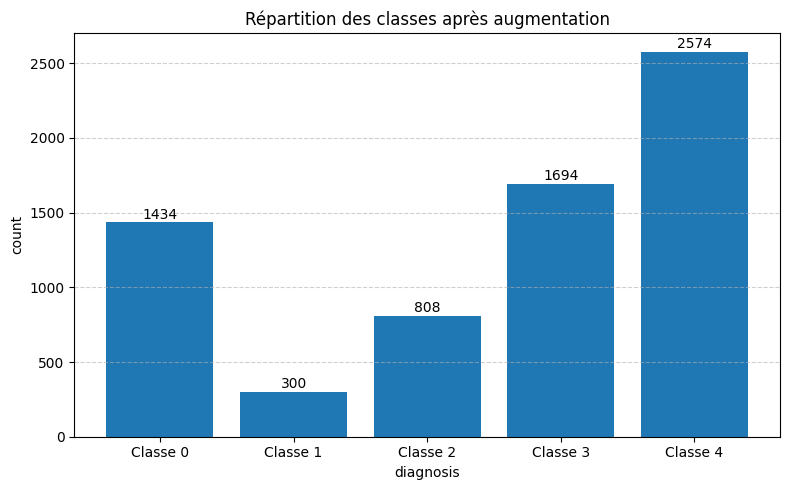

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import collections

# Charger le fichier .npz
data = np.load("../data/processed_train_images_filtred_augmented.npz")

# Adapter selon tes clés (ex: 'images' / 'labels')
y = data['labels']

# Compter les occurrences de chaque classe
counter = collections.Counter(y)
classes = sorted(counter.keys())
counts = [counter[c] for c in classes]

# Créer l'histogramme
plt.figure(figsize=(8, 5))
bars = plt.bar([f'Classe {c}' for c in classes], counts)
plt.title("Répartition des classes après augmentation")
plt.xlabel("diagnosis")
plt.ylabel("count")
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Ajouter les valeurs sur les barres
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
             str(bar.get_height()), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm


In [3]:
def apply_clahe_color(image):
    """Applique CLAHE individuellement sur les 3 canaux LAB"""
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    final = cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)
    return final

def load_and_process_images(image_dir, df, filename_col="filename", label_col="label", img_size=(224, 224)):
    X, y = [], []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        img_path = os.path.join(image_dir, row[filename_col])
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = apply_clahe_color(img)
            img = cv2.resize(img, img_size)
            img = img.astype('float32') / 255.0
            X.append(img)
            y.append(row[label_col])
    return np.array(X), np.array(y)


In [6]:
df_messidor = pd.read_csv("../data/messidor_data.csv")
print(df_messidor.columns)

Index(['id_code', 'diagnosis', 'adjudicated_dme', 'adjudicated_gradable'], dtype='object')


In [12]:
import pandas as pd

df_messidor = pd.read_csv("../data/messidor_data.csv")
df_messidor = df_messidor[["id_code", "diagnosis"]]
df_messidor.columns = ["filename", "label"]
df_messidor["filename"] = df_messidor["filename"].apply(lambda x: f"{x}.png")
df_messidor["label"] = df_messidor["label"].astype(int)

img_dir_messidor = "../data/messidor/"

X_messidor, y_messidor = load_and_process_images(img_dir_messidor, df_messidor)

np.savez("../data/processed_messidor.npz", X=X_messidor, y=y_messidor)


100%|██████████| 1744/1744 [00:00<00:00, 35379.73it/s]


In [16]:
import pandas as pd

df_idrid_train = pd.read_csv("../data/IDRiD/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv")

df_idrid_train = df_idrid_train[["Image name", "Retinopathy grade"]]
df_idrid_train.columns = ["filename", "label"]
df_idrid_train["filename"] = df_idrid_train["filename"].apply(lambda x: f"{x}.jpg")
df_idrid_train["label"] = df_idrid_train["label"].astype(int)


In [17]:
img_dir_idrid_train = "../data/IDRiD/1. Original Images/a. Training Set/"

X_idrid_train, y_idrid_train = load_and_process_images(img_dir_idrid_train, df_idrid_train)

np.savez("../data/processed_idrid_train.npz", X=X_idrid_train, y=y_idrid_train)
print("✅ IDRiD Training Set prétraité et sauvegardé avec succès.")


100%|██████████| 413/413 [00:44<00:00,  9.28it/s]


✅ IDRiD Training Set prétraité et sauvegardé avec succès.


In [19]:
aptos = np.load("../data/processed_train_images_filtred_augmented.npz")
print(aptos.files)

['images', 'labels']


In [26]:
messidor = np.load("../data/processed_messidor.npz")
print(messidor.files)

['X', 'y']


In [23]:
idrid = np.load("../data/processed_idrid_train.npz")
print(idrid.files)

['X', 'y']


In [32]:
print("APTOS :", X_aptos.shape, y_aptos.shape)
print("MESSIDOR :", X_messidor.shape, y_messidor.shape)
print("IDRiD :", X_idrid.shape, y_idrid.shape)

APTOS : (6810, 224, 224, 3) (6810,)
MESSIDOR : (0,) (0,)
IDRiD : (413, 224, 224, 3) (413,)


In [33]:
for path in df_messidor["filename"].head(5):
    print(os.path.join("../data/messidor/", path))


../data/messidor/20051020_43808_0100_PP.png.png
../data/messidor/20051020_43832_0100_PP.png.png
../data/messidor/20051020_43882_0100_PP.png.png
../data/messidor/20051020_43906_0100_PP.png.png
../data/messidor/20051020_44261_0100_PP.png.png


In [34]:
df_messidor["filename"] = df_messidor["filename"].apply(lambda x: f"{x}.jpg")  # ou .JPG


In [35]:
X_messidor, y_messidor = load_and_process_images("../data/messidor/", df_messidor)
np.savez("../data/processed_messidor.npz", X=X_messidor, y=y_messidor)


100%|██████████| 1744/1744 [00:00<00:00, 9130.95it/s]


In [36]:
print("Type MESSIDOR :", type(X_messidor), type(X_messidor[0]) if len(X_messidor) > 0 else "Empty")

Type MESSIDOR : <class 'numpy.ndarray'> Empty


In [37]:
import os

for fname in df_messidor["filename"].head(5):
    full_path = os.path.join("../data/messidor/", fname)
    print(full_path, "→", os.path.exists(full_path))


../data/messidor/20051020_43808_0100_PP.png.png.jpg → False
../data/messidor/20051020_43832_0100_PP.png.png.jpg → False
../data/messidor/20051020_43882_0100_PP.png.png.jpg → False
../data/messidor/20051020_43906_0100_PP.png.png.jpg → False
../data/messidor/20051020_44261_0100_PP.png.png.jpg → False


In [38]:
df_messidor["filename"] = df_messidor["filename"].apply(lambda x: os.path.splitext(x)[0].split(".")[0] + ".jpg")

In [39]:
X_messidor, y_messidor = load_and_process_images(img_dir_messidor, df_messidor)
np.savez("../data/processed_messidor.npz", X=X_messidor, y=y_messidor)


100%|██████████| 1744/1744 [00:06<00:00, 258.06it/s] 


In [40]:
import numpy as np

aptos = np.load("../data/processed_train_images_filtred_augmented.npz")
X_aptos, y_aptos = aptos["images"], aptos["labels"]

messidor = np.load("../data/processed_messidor.npz")
X_messidor, y_messidor = messidor["X"], messidor["y"]

idrid = np.load("../data/processed_idrid_train.npz")
X_idrid, y_idrid = idrid["X"], idrid["y"]

X_combined = np.concatenate([X_aptos, X_messidor, X_idrid], axis=0)
y_combined = np.concatenate([y_aptos, y_messidor, y_idrid], axis=0)

np.savez("../data/combined_data.npz", X=X_combined, y=y_combined)

print("✅ Fusion terminée avec succès !")
print("Total d'images combinées :", X_combined.shape[0])
print("Dimensions des images    :", X_combined.shape[1:])


✅ Fusion terminée avec succès !
Total d'images combinées : 7910
Dimensions des images    : (224, 224, 3)


In [41]:
data = np.load("../data/combined_data.npz")
X, y = data["X"], data["y"]

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


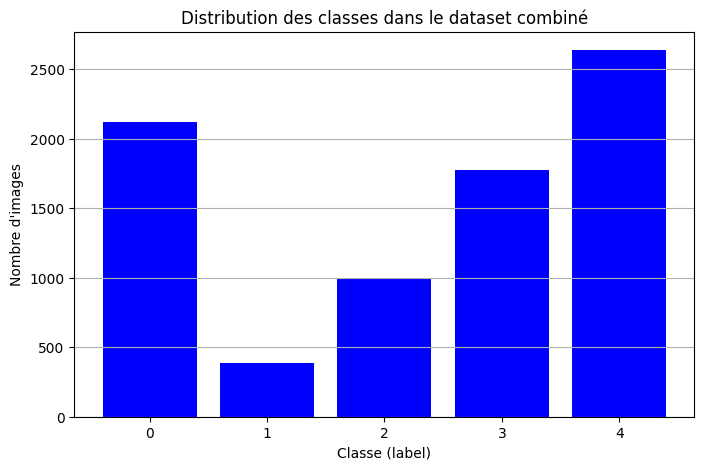

In [50]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load("../data/combined_data.npz")
y = data["y"]

unique, counts = np.unique(y, return_counts=True)

plt.figure(figsize=(8,5))
plt.bar(unique.astype(str), counts, color='blue')
plt.title("Distribution des classes dans le dataset combiné")
plt.xlabel("Classe (label)")
plt.ylabel("Nombre d'images")
plt.grid(axis='y')
plt.show()


In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

def augmenter_classe(X, y, classe_cible, n_augmentations):
    X_class = X[y == classe_cible]
    y_class = y[y == classe_cible]

    X_aug, y_aug = [], []

    for i in range(n_augmentations):
        idx = random.randint(0, len(X_class) - 1)
        img = X_class[idx]
        img = img.reshape((1,) + img.shape)

        for batch in datagen.flow(img, batch_size=1):
            X_aug.append(batch[0])
            y_aug.append(classe_cible)
            break 

    return np.array(X_aug), np.array(y_aug)

X_aug_1, y_aug_1 = augmenter_classe(X, y, classe_cible=1, n_augmentations=1000)
X_aug_2, y_aug_2 = augmenter_classe(X, y, classe_cible=2, n_augmentations=1000)


In [46]:
X_balanced = np.concatenate([X, X_aug_1, X_aug_2], axis=0)
y_balanced = np.concatenate([y, y_aug_1, y_aug_2], axis=0)

print("✅ Nouvelle forme :", X_balanced.shape, y_balanced.shape)

✅ Nouvelle forme : (9910, 224, 224, 3) (9910,)


In [47]:
np.savez("../data/combined_data_augmented.npz", X=X_balanced, y=y_balanced)
print("✅ Données sauvegardées dans combined_data_augmented.npz")


✅ Données sauvegardées dans combined_data_augmented.npz


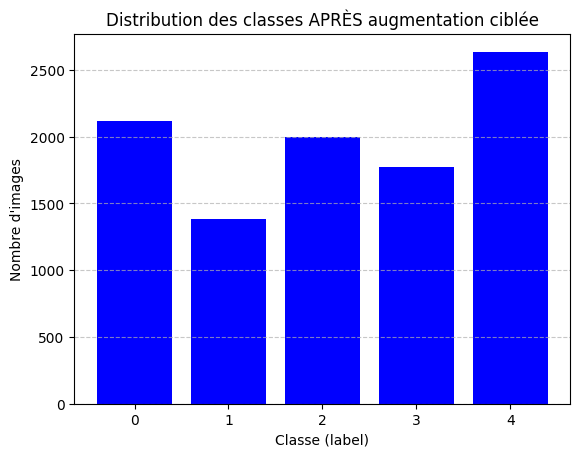

In [49]:
import matplotlib.pyplot as plt
import collections

counter_aug = collections.Counter(y_balanced)

plt.bar(counter_aug.keys(), counter_aug.values(), color='blue')
plt.title("Distribution des classes APRÈS augmentation ciblée")
plt.xlabel("Classe (label)")
plt.ylabel("Nombre d'images")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
